In [1]:
## This script evaluates the correlations between models and all experimental datasets for plotting figures
# Requires that sentence pairwise similarities have already been computed using 'Cals_sent_sim_[type].ipynb' files.
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sentence_embeds_processing as sep
import os
import json
import re

from scipy.stats import spearmanr

# file containing path directories
with open("file_paths.json", "r") as file:
    file_paths_dict = json.load(file)
    
# set display options
np.set_printoptions(precision=4, threshold=5000, linewidth=220, suppress=True, floatmode='fixed')
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set()

c:\Users\fods1\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load sentence similarity datasets

In [2]:
## Show available sentence datasets, as specified in the sentence_embeds_processing module
pairs = True # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
for dataset in datasets.keys():
    print(dataset,datasets[dataset])

0 GS2011_processed
1 KS2013_processed
2 Fodor_pilot_2022
3 STS131_processed
4 SICK_relatedness
5 STR_processed
6 STSb_captions_test
7 STSb_forums_test
8 STSb_headlines_test
9 STSb_test
10 STS3k_all


In [3]:
## Load STS3k indices sets
adv_noneg_indices = np.loadtxt('Data-experiment/STS3k_adv_noneg_indices.txt', delimiter=',', dtype='int', encoding='utf-8', skiprows=0)
non_adv_indices = np.loadtxt('Data-experiment/STS3k_non_adv_indices.txt', delimiter=',', dtype='int', encoding='utf-8', skiprows=0)
print(len(adv_noneg_indices),'adversarial non-negative pairs')
print(len(non_adv_indices),'non-adversarial pairs')

1664 adversarial non-negative pairs
1065 non-adversarial pairs


In [4]:
## Load all combinations of datasets and models
sim_storage = {}
for dataset_name in datasets.values():

    # load sentence set into dictionary depending on type
    if pairs == True:
        sentences_dict = sep.load_set_of_sentences(dataset_name, file_paths_dict['data_pairs_path'], pairs)
    else:
        sentences_dict = sep.load_set_of_sentences(dataset_name, file_paths_dict['neuro_root'], pairs)
    n = len(sentences_dict.keys()) # num sentences
    print('\nloaded',dataset_name,'with',n,'sentences')

    # get experimental similarities for sentence pairs    
    sim_storage[dataset_name] = {}
    sim_storage[dataset_name]['expr'] = np.array(list(sentences_dict.values()))[:,2].astype(float)

    # loop over all model functions to load data
    all_files = os.listdir(file_paths_dict['sims_path'])
    count = 0
    for file_name in all_files:
        
        # Regular expression pattern to match files for given model
        filename_pattern = r"^{}.*\.txt$".format(dataset_name)

        # Check if the filename matches the desired filename_pattern
        if re.match(filename_pattern, file_name):
            basename_pattern = r"{}_(.*?)_similarities.txt".format(dataset_name) # extract basename to save
            base_name = sep.extract_text_between(basename_pattern, file_name)[0]
            sim_storage[dataset_name][base_name] = arr_no_nan = np.nan_to_num(sep.load_sentence_sim_values(file_paths_dict['sims_path']+file_name))
            count+=1
            
    print(count,'files loaded')


loaded GS2011_processed with 199 sentences
34 files loaded

loaded KS2013_processed with 108 sentences
32 files loaded

loaded Fodor_pilot_2022 with 120 sentences
20 files loaded

loaded STS131_processed with 131 sentences
32 files loaded

loaded SICK_relatedness with 9840 sentences
32 files loaded

loaded STR_processed with 5500 sentences
42 files loaded

loaded STSb_captions_test with 624 sentences
36 files loaded

loaded STSb_forums_test with 254 sentences
32 files loaded

loaded STSb_headlines_test with 500 sentences
3 files loaded

loaded STSb_test with 1140 sentences
31 files loaded

loaded STS3k_all with 2800 sentences
51 files loaded


### Compute correlations between sentence similarities across datasets

In [5]:
## Compute correlations for selected datasets

datasets_to_plot = ['STSb_captions_test', 'STSb_forums_test', 'STSb_test', 'SICK_relatedness', 'STS131_processed', 'STR_processed', 'STS3k_all', 'STS3k_nonadv', 'STS3k_adv']
models_to_plot = ['vocab','mean', 'mult', 'conv', 'infersent', 'universal_norml', 'ernie_0_norml', 'ernie_12_norml',  
                  'sentbert_mpnet_norml', 'openai_norml', 'defsent_cls_norml', 'smatch', 'WLK_Wasser', 'S3BERT_norml', 'amrbart_norml',
                  'AMR', 'verbnet_fixedparms_basic', 'verbnet_fixedparms_norm', 'GPT4_fixedparms_basic', 'GPT4_fixedparms_norm', 'GPT4o_fixedparms_basic', 'GPT4o_fixedparms_norm']
datasets_shortnames = ['STSb-c', 'STSb-f', 'STSb', 'SICK', 'STSS-131', 'STR', 'STS3k-all', 'STS3k-non', 'STS3k-adv']
models_shortnames = ['Vocab','Mean-CN', 'Mult-CN', 'Conv-CN', 'InferSent', 'USE', 'ERNIE-0', 'ERNIE-12',
                     'SentBERT', 'OpenAI', 'DefSent', 'AMR-Smatch', 'AMR-WWLK', 'S3BERT', 'AMRBART',
                     'AMR-CN', 'VerbNet-CN', 'VerbNet-CN-norm', 'GPT4-CN', 'GPT4-CN-norm', 'GPT4o-CN', 'GPT4o-CN-norm']
corr_storage = np.zeros((len(models_to_plot), len(datasets_to_plot)))
i = 0
j = 0

for dataset_name in datasets_to_plot:
    j=0
    for model in models_to_plot:
        try:
            if dataset_name=='STS3k_adv': # special case
                model_sims = sim_storage['STS3k_all'][model][adv_noneg_indices]
                expr_sims = sim_storage['STS3k_all']['expr'][adv_noneg_indices]
            elif dataset_name=='STS3k_nonadv': # special case
                model_sims = sim_storage['STS3k_all'][model][non_adv_indices]
                expr_sims = sim_storage['STS3k_all']['expr'][non_adv_indices]
            else: # all other cases
                model_sims = sim_storage[dataset_name][model]
                expr_sims = sim_storage[dataset_name]['expr']
            corr,_ = spearmanr(model_sims,expr_sims)
        except:
            corr = np.NaN
        corr_storage[j,i] = corr
        j+=1
    i+=1

In [17]:
## Model-model similarity correlations
np.corrcoef(sim_storage['STS3k_all']['verbnet_conceptnet_fixedparms_basic'], sim_storage['STS3k_all']['GPT4_fixedparms_basic'])

array([[1.0000, 0.9204],
       [0.9204, 1.0000]])

In [6]:
## Print table of key correlations
df = pd.DataFrame(corr_storage, columns = datasets_shortnames, index = models_shortnames)
df

,STSb-c,STSb-f,STSb,SICK,STSS-131,STR,STS3k-all,STS3k-non,STS3k-adv
Vocab,0.745,0.515,0.674,0.563,0.790,0.543,0.515,0.760,0.153
Mean-CN,0.806,0.519,0.689,0.597,0.871,0.612,0.368,0.800,-0.291
Mult-CN,0.259,0.278,0.168,0.273,0.273,0.057,0.096,0.450,-0.333
Conv-CN,0.164,0.271,0.158,0.268,0.078,0.057,-0.042,0.323,-0.462
InferSent,0.798,0.428,0.661,0.663,0.868,0.657,0.445,0.830,-0.088
USE,0.881,0.714,0.795,0.702,0.900,0.746,0.442,0.824,-0.071
ERNIE-0,NaN,0.543,0.597,0.615,0.749,0.592,0.423,0.799,-0.107
ERNIE-12,0.604,0.715,0.549,0.597,0.809,0.617,0.576,0.834,0.227
SentBERT,0.929,0.719,0.836,0.803,0.939,0.821,0.580,0.866,0.145
OpenAI,0.923,0.829,0.835,0.804,0.960,0.847,0.598,0.890,0.184


### Plot graphs of model correlations

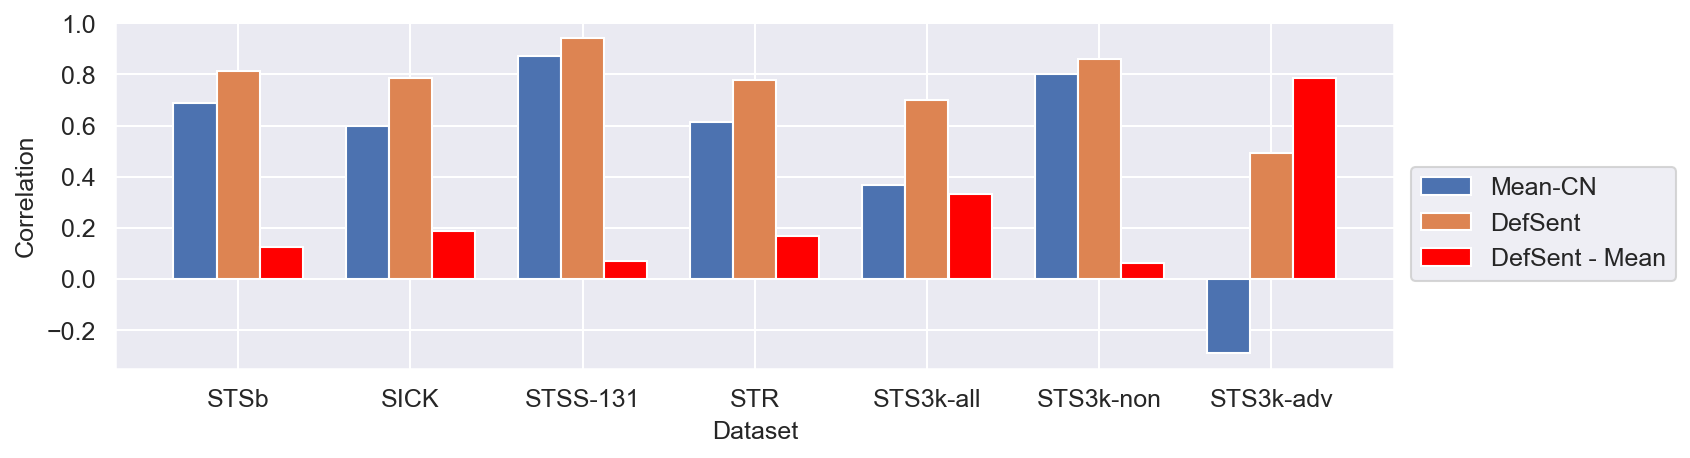

In [22]:
## Plot bar graphs with correlations and differences

# Correlation set to analyse
corr_analyse = corr_storage[:,2:]
names_analyse = datasets_shortnames[2:]

# Plot parameters
x_axis = np.arange(len(corr_analyse[0]))
offsets = 1/2
bar_width = 0.25
font_size = 12

# Generate bar plot
fig, ax = plt.subplots(figsize=(11,3), dpi=150)
plt.bar(x=x_axis-offsets*2*bar_width, height=corr_analyse[0], width=bar_width, label='Mean-CN')
plt.bar(x=x_axis, height=corr_analyse[9], width=bar_width, label='DefSent')
plt.bar(x=x_axis+offsets*2*bar_width, height=corr_analyse[9]-corr_analyse[0], width=bar_width, label='DefSent - Mean', color='red')
plt.xticks(x_axis, names_analyse, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.23, 0.62), loc='upper right')
plt.ylabel('Correlation', fontsize=font_size)
plt.xlabel('Dataset', fontsize=font_size)
plt.show()

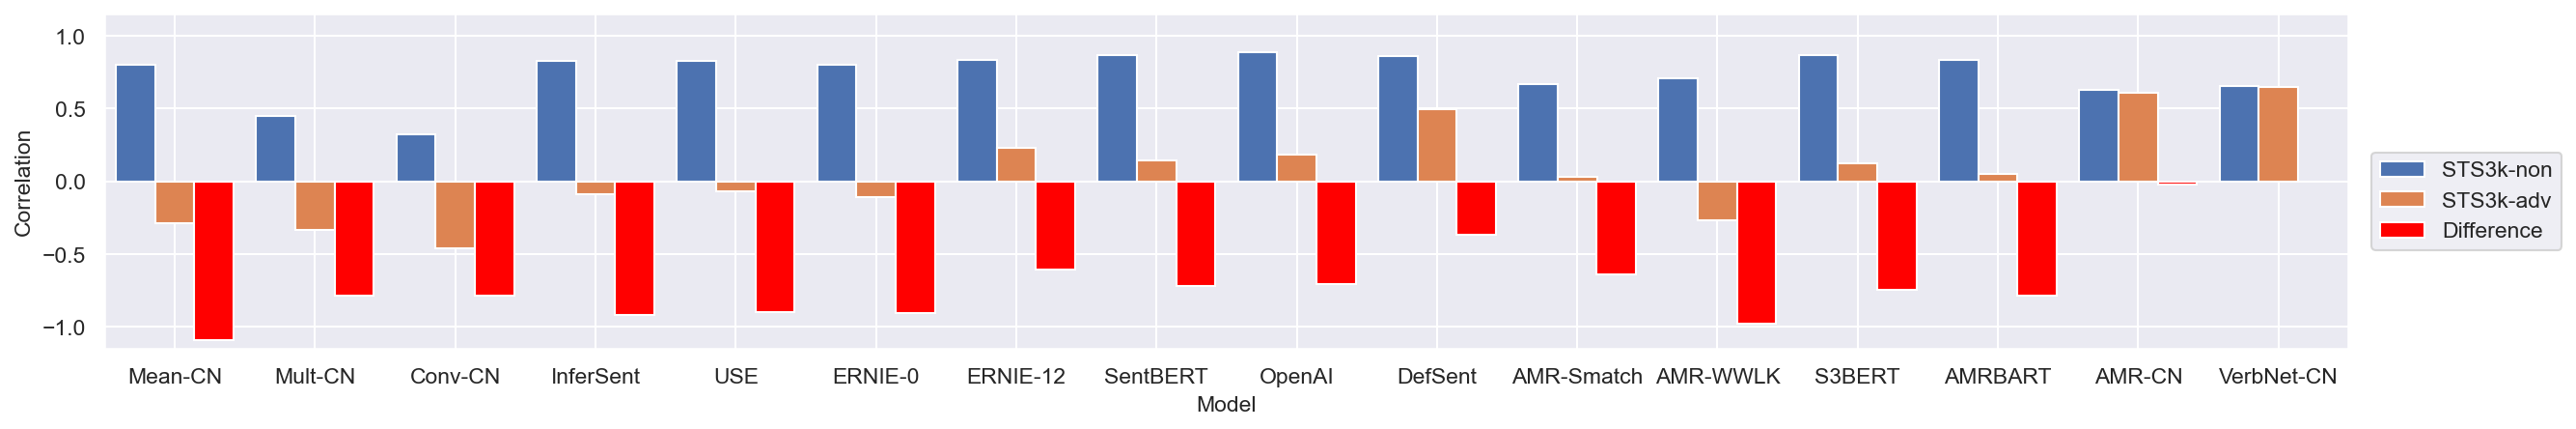

In [18]:
## Plot bar graphs with correlations and differences

# Correlation set to analyse
corr_analyse = corr_storage

# Plot parameters
x_axis = np.arange(len(corr_analyse[:,0]))
offsets = 1/2
bar_width = 0.28
font_size = 11

# Generate bar plot
fig, ax = plt.subplots(figsize=(20,3), dpi=150)
plt.bar(x=x_axis-offsets*2*bar_width, height=corr_analyse[:,7], width=bar_width, label='STS3k-non')
plt.bar(x=x_axis, height=corr_analyse[:,8], width=bar_width, label='STS3k-adv')
plt.bar(x=x_axis+offsets*2*bar_width, height=corr_analyse[:,8]-corr_analyse[:,7], width=bar_width, label='Difference', color='red')
plt.xticks(x_axis, models_shortnames, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.10, 0.62), loc='upper right')
plt.ylabel('Correlation', fontsize=font_size)
plt.xlabel('Model', fontsize=font_size)
plt.xlim(xmax = 15.5, xmin = -0.5)
plt.ylim(ymax = 1.15, ymin = -1.15)
plt.show()